## Propensity Score Matching 
In Propensity Score Matching (PSM), we aim to estimate the Conditional Average Treatment Effect (CATE) — the effect of a treatment (e.g., a mindset intervention) on individuals based on their characteristics (covariates)
Define the Problem:

* Treatment: Whether a student received the intervention (1 = Yes, 0 = No).
* Outcome: What we want to measure (e.g., test score improvement).
* Covariates: Characteristics like age, gender, and prior performance that may influence both treatment and outcome.

Example: Alice received the treatment, her test score improved by 10 points. Bob did not receive the treatment, his score improved by 5 points.

## Estimate Propensity Scores:
We use logistic regression to estimate the probability (propensity score) that each student receives the treatment based on their covariates.

Example: Alice has a high propensity score (e.g., 0.85), and Bob has a low score (e.g., 0.25).

### Matching:
We match treated students (like Alice) with control students (like Charlie) who have similar propensity scores (e.g., Charlie’s score is 0.82, but he didn’t receive the treatment).

This helps compare students who are similar except for whether they got the treatment.

### Estimate CATE:
For each matched pair, we calculate the difference in outcomes. Example: Alice’s test score improved by 10 points, and Charlie’s improved by 7. So, the treatment effect for Alice is 10 - 7 = 3points.
We do this for all matched pairs and take the average to get the overall CATE.

Example: If other students had treatment effects of 2 and 4 points, the average CATE might be:

Average CATE= (3+2+4)/3 = 3

This means, on average, the intervention increased test score improvements by 3 points.

To estimate the Conditional Average Treatment Effect (CATE) using Propensity Score Matching (PSM) on the the synthetic data regarding mindsets of student:

    * Preprocess the data (loading and handling covariates).
    * Estimate the propensity scores using logistic regression.
    * Perform Propensity Score Matching (PSM) using nearest-neighbor matching.
    * Estimate the CATE by comparing the outcomes of matched treated and control groups

# Propensity Score Matching (PSM)
Using logistic regression, we estimate the propensity scores and perform nearest neighbor matching to get the CATE estimates based on PSM

c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Estimated Average CATE (PSM): 0.2558249286643359


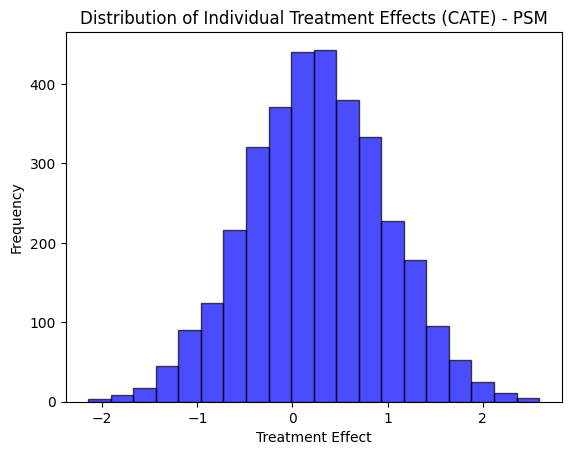

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('../../data/analysis_data/dataset.csv')

# Define the treatment, covariates, and outcome
treatment_col = 'Z'
outcome_col = 'Y'
covariates = data.drop(columns=[treatment_col, outcome_col])

# Step 1: Estimate the propensity score using logistic regression
logistic_model = LogisticRegression()
logistic_model.fit(covariates, data[treatment_col])
data['propensity_score'] = logistic_model.predict_proba(covariates)[:, 1]

# Step 2: Perform Propensity Score Matching (PSM) - Nearest Neighbor Matching
treated = data[data[treatment_col] == 1]
control = data[data[treatment_col] == 0]
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Step 3: Match treated individuals with control individuals based on nearest neighbors
matched_control = control.iloc[indices.flatten()]

# Step 4: Estimate CATE for PSM
cate = treated[outcome_col].reset_index(drop=True) - matched_control[outcome_col].reset_index(drop=True)
average_cate = cate.mean()
print(f"Estimated Average CATE (PSM): {average_cate}")

# Step 5: Display distribution of individual CATE estimates for PSM
plt.hist(cate, bins=20, edgecolor='k', alpha=0.7, color="blue")
plt.title('Distribution of Individual Treatment Effects (CATE) - PSM')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()


The histogram above shows the Distribution of Individual Treatment Effects (CATE) - PSM:

* This chart shows the distribution of CATE estimates from the PSM method.
* The distribution is centered around zero with a spread across the positive and negative range.
* This suggests that PSM captures individual treatment effects, but the effects are highly variable.

# Assess Covariate Balance After PSM
Assess the covariate balance to see if PSM successfully created comparable groups.

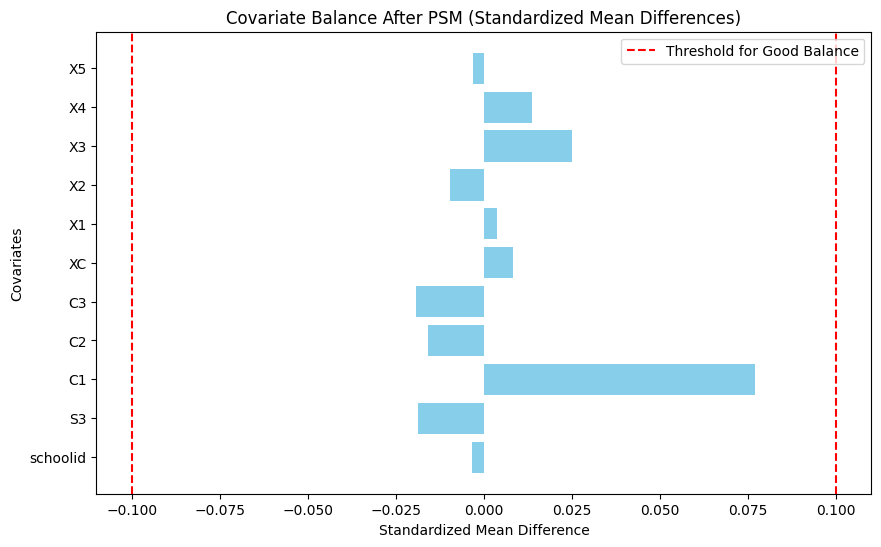

In [2]:
# Function to calculate standardized mean difference
def standardized_mean_difference(treated, control, covariate):
    return (treated[covariate].mean() - control[covariate].mean()) / np.sqrt(0.5 * (treated[covariate].var() + control[covariate].var()))

covariate_balance = {covariate: standardized_mean_difference(treated, matched_control, covariate) for covariate in covariates.columns}

# Plot covariate balance to highlight limitations
plt.figure(figsize=(10, 6))
plt.barh(list(covariate_balance.keys()), covariate_balance.values(), color='skyblue')
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold for Good Balance')
plt.axvline(x=-0.1, color='red', linestyle='--')
plt.title("Covariate Balance After PSM (Standardized Mean Differences)")
plt.xlabel("Standardized Mean Difference")
plt.ylabel("Covariates")
plt.legend()
plt.show()


Covariate Balance After PSM:

* This plot shows the standardized mean differences for covariates after matching.
* Many covariates still exceed the threshold (indicated by the red dashed lines) for "good balance" (within ±0.1).
* Poor balance in covariates suggests that PSM may not have adequately controlled for confounding variables, potentially biasing CATE estimates.

# Load Meta-Learner Predictions for Comparison


In [4]:
# Load Meta-Learner Predictions
s_predictions = pd.read_csv('../../results/s_predictions.csv')
t_predictions = pd.read_csv('../../results/t_predictions.csv')
x_predictions = pd.read_csv('../../results/x_predictions.csv')
r_predictions = pd.read_csv('../../results/r_predictions.csv')


# Visualize CATE Distributions for PSM and Meta-Learners
Compare the distributions of CATE estimates from PSM and each meta-learner to see if meta-learners provide more reliable and consistent estimates.

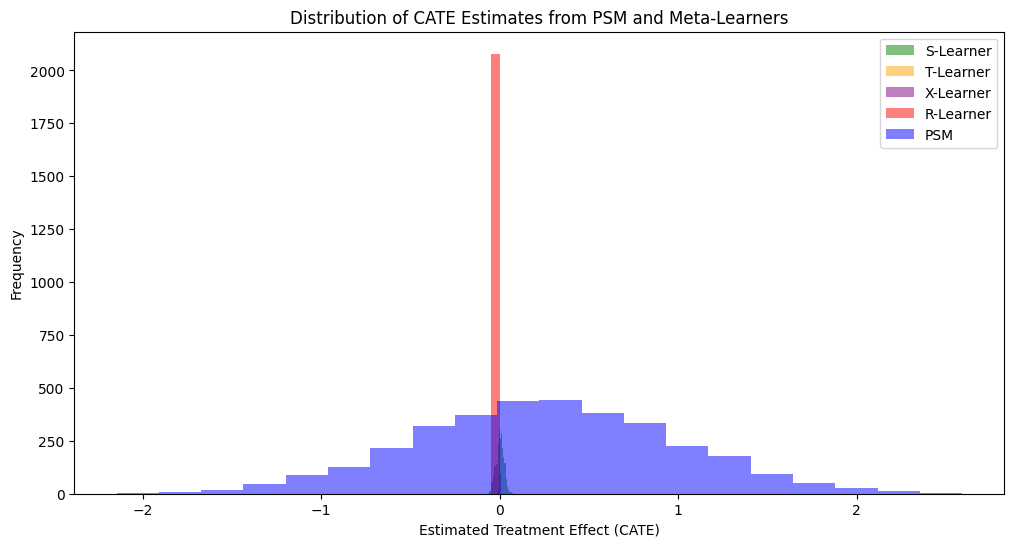

In [5]:
plt.figure(figsize=(12, 6))
plt.hist(s_predictions['s_CATE'], bins=20, alpha=0.5, label="S-Learner", color="green")
plt.hist(t_predictions['t_CATE'], bins=20, alpha=0.5, label="T-Learner", color="orange")
plt.hist(x_predictions['x_CATE'], bins=20, alpha=0.5, label="X-Learner", color="purple")
plt.hist(r_predictions['r_CATE'], bins=20, alpha=0.5, label="R-Learner", color="red")
plt.hist(cate, bins=20, alpha=0.5, label="PSM", color="blue")
plt.title("Distribution of CATE Estimates from PSM and Meta-Learners")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Distribution of CATE Estimates from PSM and Meta-Learners:

* This plot overlays the CATE distributions from PSM and the different meta-learners.
* Meta-learner distributions (S, T, X, and R learners) appear much narrower and are concentrated around zero, whereas PSM shows a broader distribution.
* The narrow distribution in meta-learners indicates more consistency in the estimated CATE, whereas PSM suggests greater variability in treatment effects.

# RMSE Comparison of CATE Estimates Against Average Treatment Effect (ATE)
Using the overall Average Treatment Effect (ATE) as a benchmark, calculate the RMSE for each method.

Overall Average Treatment Effect (ATE): 0.30367484224901825
Comparison of CATE Estimates to the ATE:
      Method  Mean Treatment Estimates  RMSE with ATE
0        PSM              2.558249e-01       0.722366
1  S-Learner              1.335346e-03       0.303181
2  T-Learner             -1.513164e-05       0.303690
3  X-Learner             -5.682505e-05       0.303748
4  R-Learner              1.249538e-12       0.303675


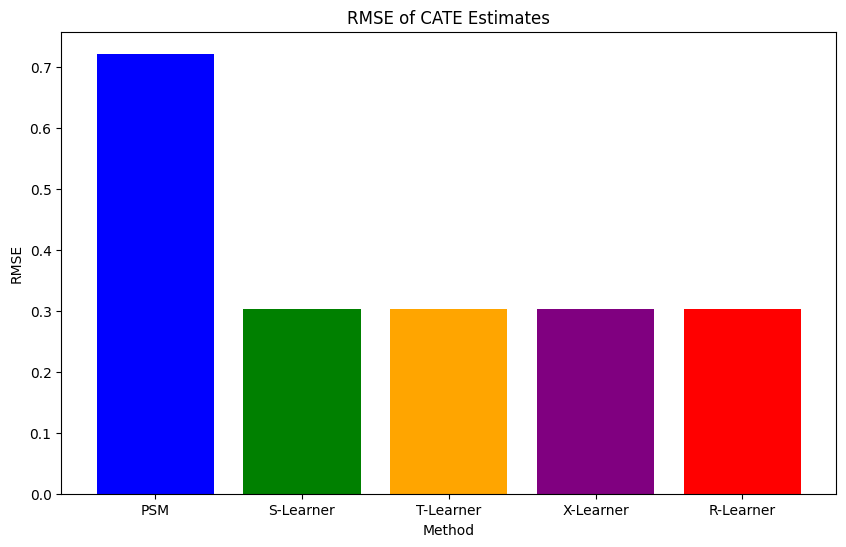

In [6]:
from sklearn.metrics import mean_squared_error

# Calculate the Average Treatment Effect (ATE) as a benchmark
treatment_effect_mean = data[data['Z'] == 1]['Y'].mean() - data[data['Z'] == 0]['Y'].mean()
print(f"Overall Average Treatment Effect (ATE): {treatment_effect_mean}")

# Calculate RMSE for each method's CATE estimates against the ATE
cate_data = {
    'Method': ['PSM', 'S-Learner', 'T-Learner', 'X-Learner', 'R-Learner'],
    'Mean Treatment Estimates': [
        cate.mean(),
        s_predictions['s_CATE'].mean(),
        t_predictions['t_CATE'].mean(),
        x_predictions['x_CATE'].mean(),
        r_predictions['r_CATE'].mean()
    ],
    'RMSE with ATE': [
        mean_squared_error([treatment_effect_mean] * len(cate), cate, squared=False),
        mean_squared_error([treatment_effect_mean] * len(s_predictions['s_CATE']), s_predictions['s_CATE'], squared=False),
        mean_squared_error([treatment_effect_mean] * len(t_predictions['t_CATE']), t_predictions['t_CATE'], squared=False),
        mean_squared_error([treatment_effect_mean] * len(x_predictions['x_CATE']), x_predictions['x_CATE'], squared=False),
        mean_squared_error([treatment_effect_mean] * len(r_predictions['r_CATE']), r_predictions['r_CATE'], squared=False)
    ]
}

cate_summary = pd.DataFrame(cate_data)
print("Comparison of CATE Estimates to the ATE:")
print(cate_summary)

# Visualize RMSE with ATE across methods
plt.figure(figsize=(10, 6))
plt.bar(cate_summary['Method'], cate_summary['RMSE with ATE'], color=['blue', 'green', 'orange', 'purple', 'red'])
plt.title("RMSE of CATE Estimates")
plt.xlabel("Method")
plt.ylabel("RMSE")
plt.show()


RMSE of CATE Estimates with the ATE:

* This chart compares the Root Mean Squared Error (RMSE) between each method's CATE estimates and the observed Average Treatment Effect (ATE).
* PSM has the highest RMSE, suggesting a less accurate estimation of CATE relative to the observed ATE.
* Meta-learners (S, T, X, and R learners) all have lower RMSEs, indicating that their CATE estimates are closer to the ATE on average